# Redes Sociais - Projeto: Pokémon TCG

### Alunos: Arthur Barreto, Enricco Gemha e Felipe Catapano


## Pré-requisitos

In [1]:
import graph_tool_extras as gte
import netpixi
from graph_tool import draw
import distribution as dst
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import regression as reg
%matplotlib inline

In [2]:
PATH = 'tournaments.csv'

## Análise dos dados importados

Filtrando para cartas do tipo `Pokémon`, ou seja, as que não são `Trainer`.

O arquivo csv possui as seguintes colunas:

1. id_card;
2. name_card;
3. amount_card;
4. price_card;
5. energy_type_card;
6. type_card;
7. combo_type_id;
8. combo_type_name;
9. id_player;
10. name_player;
11. country_player;
12. all_time_score;
13. ranking_player_tournament;
14. id_tournament;
15. category_tournament;
16. name_tournament;
17. region_tournament;
18. country_tournament;
19. year_tournament;
20. month_tournament;
21. day_tournament;
22. valid_rotation_at_tournament;
23. current_rotation_name;
24. current_rotation_year;
25. current_rotation_month;
26. current_rotation_day;

In [3]:
def get_or_add_vertex(g, id, bipartite):
    u = g.vertex_by_id(id)
    if u is None:
        u = g.add_vertex_by_id(id)
        # Combos are True (1) and cards are False (0)
        u['bipartite'] = bipartite
        u['color'] = 0xffffff if bipartite else 0xff0000
    return u

def get_or_add_edge(g, id1, id2):
    e = g.edge_by_ids(id1, id2)
    if e is None:
        e = g.add_edge_by_ids(id1, id2)
    return e

In [4]:
def get_data_from_row(row):
    row = row.split(',')
    if row[5] != 'Trainer':
        # devemos retornar:
            # 1. id do combo (row[6])
            # 2. nome da carta (row[0])
            # 3. ranking da carta no torneio (row[12])
            # 4. quantidade de uma mesma cópia no combo (row[2])
            # 5. categoria do torneio disputado (row[14])
            # 6. região do torneio disputado (row[16])
            # 7. rotation name (row[22])
        return row[6], row[0], row[12], row[2], row[14], row[16], row[22]
    return None, None, None, None, None, None, None

In [5]:
rotation_list = ['standard_2011','standard_2012','standard_2013','standard_2014','standard_2015','standard_2016','standard_2017','standard_2018','standard_2019','standard_2020','standard_2021','standard_2022','standard_2023']

combo_card_list = {k: [] for k in rotation_list}
card_ranks = {k: {} for k in rotation_list}
card_copies = {k: {} for k in rotation_list}
ct_cat = {k: {} for k in rotation_list} # tournament categories for each card
ct_regions = {k: {} for k in rotation_list} # tournament regions for each card

all_tournament_cat = []
all_tournament_regions = []

with open(PATH) as f:
    next(f) # skip header

    for row in f:

        # Get data from row
        combo_id, card_id, rk, cp, tcat, reg, rot = get_data_from_row(row)

        if combo_id == None and card_id == None and rk == None and cp == None and tcat == None and reg == None:
            continue

        if tcat not in all_tournament_cat:
            all_tournament_cat.append(tcat)
        if reg not in all_tournament_regions:
            all_tournament_regions.append(reg)

        if card_id in card_ranks[rot]:
            card_ranks[rot][card_id].append(int(rk))
            card_copies[rot][card_id].append(int(cp))
            ct_cat[rot][card_id].append(tcat)
            ct_regions[rot][card_id].append(reg)

        if card_id not in card_ranks[rot]:
            card_ranks[rot][card_id] = [int(rk)]
            card_copies[rot][card_id] = [int(cp)]
            ct_cat[rot][card_id] = [tcat]
            ct_regions[rot][card_id] = [reg]
            
        combo_card_list[rot].append((combo_id, card_id))

In [6]:
for rot in rotation_list:
    for card in card_ranks[rot]:
        weighted_rank = 0
        for rank in card_ranks[rot][card]:
            weighted_rank += 1/math.log(rank+1)
        card_ranks[rot][card] = weighted_rank / len(card_ranks[rot][card])

    for card in card_copies[rot]:
        card_copies[rot][card] = sum(card_copies[rot][card]) / len(card_copies[rot][card])

    ct_cat_copy = ct_cat[rot].copy()
    for card_code in ct_cat_copy:
        ct_cat[rot][card_code] = []
        card = ct_cat_copy[card_code]
        # Count for each possible category and create a list of tuples (category, count)
        for category in all_tournament_cat:
            card_count = card.count(category)
            ct_cat[rot][card_code].append((category, card_count))

    ct_regions_copy = ct_regions[rot].copy()
    for card_code in ct_regions_copy:
        ct_regions[rot][card_code] = []
        card = ct_regions_copy[card_code]
        # Count for each possible region and create a list of tuples (region, count)
        for region in all_tournament_regions:
            card_count = card.count(region)
            ct_regions[rot][card_code].append((region, card_count))

## Montagem da Rede

In [7]:
centralities_betweenness = {k: {} for k in rotation_list}

for rot in rotation_list:
    # Create undirected graph
    g = gte.Graph(directed=False)
    g.add_vp('bipartite')
    g.add_vp('color')
    unique_cards = []
    # Add vertices and edges to graph
    for combo_id, card_id in combo_card_list[rot]:
        if card_id not in unique_cards:
            unique_cards.append(card_id)
        get_or_add_vertex(g, combo_id, bipartite=1)
        get_or_add_vertex(g, card_id, bipartite=0)
        get_or_add_edge(g, combo_id, card_id)

    #layout = gte.bipartite_layout(g, 'bipartite', lambda value: bool(value))
    layout = draw.sfdp_layout(g)

    gte.move(g, layout)

    c = gte.bipartite_betweenness(g, 'bipartite', lambda value: bool(value))
    g.add_vp('betweenness', c)
    # add the betweenness centrality in centralities_betweenness[rot], which is a dict of dicts, and receives the rotation name as key
    # and the value is a dict that receives the card id as key and the betweenness value for that card as value
    for card in unique_cards:
        centralities_betweenness[rot][card] = g.vertex_by_id(card)['betweenness']

    gte.save(g, f'subnetworks/pokemontcg_{rot}.net.gz')

## Regressão (hipótese 1)

Modelo linear no qual card_ranking é a variável dependente e betweenness_centrality é uma das variáveis independentes

In [8]:
dataframes = []
for rot in rotation_list:
    data = pd.DataFrame.from_dict(card_ranks[rot], orient='index', columns=['card_ranking'])
    
    # for each card_id, which is the index of the dataframe, add the betweenness centrality value
    for card in centralities_betweenness[rot]:
        data.loc[card, 'betweenness_centrality'] = centralities_betweenness[rot][card]

    # card_copies, ct_cat, ct_regions
    for card in card_copies[rot]:
        data.loc[card, 'card_copies_avg'] = card_copies[rot][card]

    for card in ct_cat[rot]:
        for category, count in ct_cat[rot][card]:
            if category in all_tournament_cat:
                all_tournament_cat.remove(category)
            data.loc[card, f'category_count_{category}'] = count
    if len(all_tournament_cat) > 0:
        for category in all_tournament_cat:
            data[f'category_count_{category}'] = 0
    
    for card in ct_regions[rot]:
        for region, count in ct_regions[rot][card]:
            if region in all_tournament_regions:
                all_tournament_regions.remove(region)
            data.loc[card, f'region_count_{region}'] = count
    if len(all_tournament_regions) > 0:
        for region in all_tournament_regions:
            data[f'category_count_{region}'] = 0
        

    # normalize the columns that contain the name 'count'
    for column in data.columns:
        if 'count' in column:
            data[f'norm_{column}'] = data[column] / data[column].max()
            data.drop(column, axis=1, inplace=True)


    dataframes.append(data)

data = pd.concat(dataframes)
data.fillna(0, inplace=True)
data['norm_region_count_AS_OC'] = data['norm_region_count_AS-OC']
data.drop('norm_region_count_AS-OC', axis=1, inplace=True)

data

,card_ranking,betweenness_centrality,card_copies_avg,norm_category_count_regional,norm_category_count_national,norm_category_count_international,norm_category_count_worlds,norm_category_count_others,norm_region_count_NA,norm_region_count_SA,norm_region_count_EU,norm_region_count_JP,norm_region_count_AS_OC
TM068,0.685101,0.061254,3.75,0.0,0.0,0.0,0.500,0.000000,0.500,0.0,0.000000,0.0,0.0
TM043,0.685101,0.061254,1.25,0.0,0.0,0.0,0.500,0.000000,0.500,0.0,0.000000,0.0,0.0
TM096,0.685101,0.061254,3.75,0.0,0.0,0.0,0.500,0.000000,0.500,0.0,0.000000,0.0,0.0
BLW015,1.442695,0.000000,3.00,0.0,0.0,0.0,0.125,0.000000,0.125,0.0,0.000000,0.0,0.0
BLW018,1.442695,0.000000,1.00,0.0,0.0,0.0,0.125,0.000000,0.125,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SVP037,0.288539,0.000000,1.00,0.0,0.0,0.0,0.000,0.010753,0.000,0.0,0.006849,0.0,0.0
BST120,0.288539,0.000000,1.00,0.0,0.0,0.0,0.000,0.010753,0.000,0.0,0.006849,0.0,0.0
CRE089,0.288539,0.000000,1.00,0.0,0.0,0.0,0.000,0.010753,0.000,0.0,0.006849,0.0,0.0
CRE090,0.288539,0.000000,1.00,0.0,0.0,0.0,0.000,0.010753,0.000,0.0,0.006849,0.0,0.0


In [9]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
card_ranking,1834.0,0.428763,0.195107,0.19585,0.30074,0.378923,0.488837,1.442695
betweenness_centrality,1834.0,0.014089,0.074944,0.00000,0.00000,0.000000,0.003339,2.193020
card_copies_avg,1834.0,1.902928,1.005912,1.00000,1.00000,1.534299,2.666667,4.000000
norm_category_count_regional,1834.0,0.018976,0.085817,0.00000,0.00000,0.000000,0.000000,1.000000
norm_category_count_national,1834.0,0.057807,0.163967,0.00000,0.00000,0.000000,0.000000,1.000000
norm_category_count_international,1834.0,0.051672,0.129222,0.00000,0.00000,0.000000,0.034945,1.000000
norm_category_count_worlds,1834.0,0.074974,0.163165,0.00000,0.00000,0.000000,0.076923,1.000000
norm_category_count_others,1834.0,0.043761,0.112599,0.00000,0.00000,0.000000,0.029197,1.000000
norm_region_count_NA,1834.0,0.088335,0.165364,0.00000,0.00000,0.020408,0.100000,1.000000
norm_region_count_SA,1834.0,0.043213,0.127958,0.00000,0.00000,0.000000,0.015152,1.000000


In [10]:
data.corr()

,card_ranking,betweenness_centrality,card_copies_avg,norm_category_count_regional,norm_category_count_national,norm_category_count_international,norm_category_count_worlds,norm_category_count_others,norm_region_count_NA,norm_region_count_SA,norm_region_count_EU,norm_region_count_JP,norm_region_count_AS_OC
card_ranking,1.000000,0.060879,0.007055,-0.115893,0.132405,-0.071580,0.118771,-0.067305,0.104225,-0.051128,0.070258,-0.053852,0.056270
betweenness_centrality,0.060879,1.000000,-0.043777,0.112294,0.215135,0.258301,0.435619,0.240992,0.466485,0.210504,0.274960,0.259477,0.298606
card_copies_avg,0.007055,-0.043777,1.000000,-0.018730,0.082511,0.026403,0.091533,-0.018682,0.069325,0.006231,0.060481,-0.012595,0.029278
norm_category_count_regional,-0.115893,0.112294,-0.018730,1.000000,0.268944,0.510090,0.263917,0.619338,0.417846,0.609886,0.444117,0.475183,0.432408
norm_category_count_national,0.132405,0.215135,0.082511,0.268944,1.000000,0.214304,0.560281,0.196306,0.543893,0.174306,0.513478,0.316049,0.393436
norm_category_count_international,-0.071580,0.258301,0.026403,0.510090,0.214304,1.000000,0.361782,0.687401,0.507553,0.791417,0.623432,0.635090,0.638894
norm_category_count_worlds,0.118771,0.435619,0.091533,0.263917,0.560281,0.361782,1.000000,0.273259,0.767957,0.265661,0.499073,0.280544,0.370807
norm_category_count_others,-0.067305,0.240992,-0.018682,0.619338,0.196306,0.687401,0.273259,1.000000,0.421641,0.609080,0.519886,0.816826,0.598081
norm_region_count_NA,0.104225,0.466485,0.069325,0.417846,0.543893,0.507553,0.767957,0.421641,1.000000,0.424895,0.589113,0.388579,0.535121
norm_region_count_SA,-0.051128,0.210504,0.006231,0.609886,0.174306,0.791417,0.265661,0.609080,0.424895,1.000000,0.467316,0.574888,0.603842


In [11]:
import regression as reg
name_var_y, name_var_x = list(data.columns)[0], ' + '.join(list(data.columns)[1:])

result = reg.linear(data=data, formula=f'{name_var_y} ~ {name_var_x}') # dependente à esquerda!
result.micro_summary()

variable,coefficient,std error,p-value
betweenness_centrality,-0.016116,0.068917,0.815128
card_copies_avg,-0.003332,0.004427,0.451746
norm_category_count_regional,-0.483245,0.075449,0.000000
norm_category_count_national,0.081365,0.039109,0.037622
norm_category_count_international,-0.367700,0.070155,0.000000
norm_category_count_worlds,0.052155,0.044986,0.246467
norm_category_count_others,0.064551,0.085157,0.448537
norm_region_count_NA,0.114082,0.049355,0.020917
norm_region_count_SA,0.175082,0.063827,0.006146
norm_region_count_EU,0.131170,0.044374,0.003156


Plotando os dados da regressão

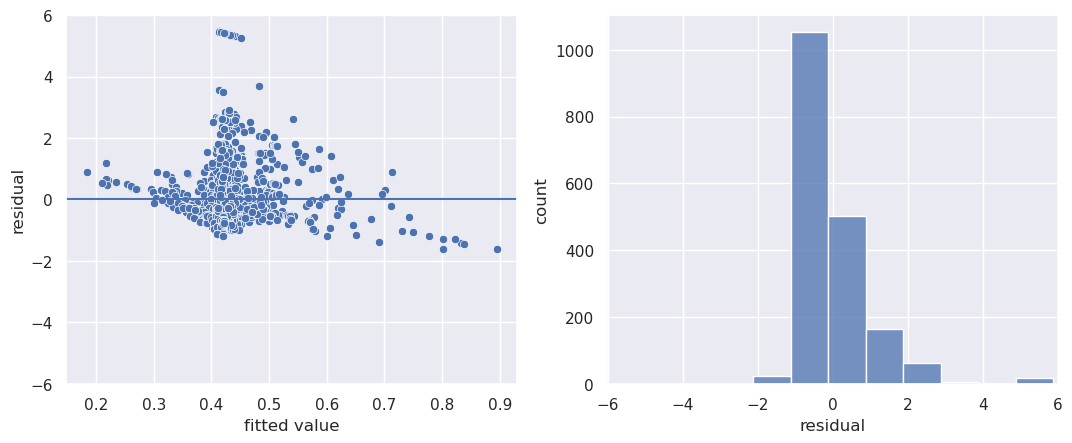

In [12]:
result.plot_residuals()

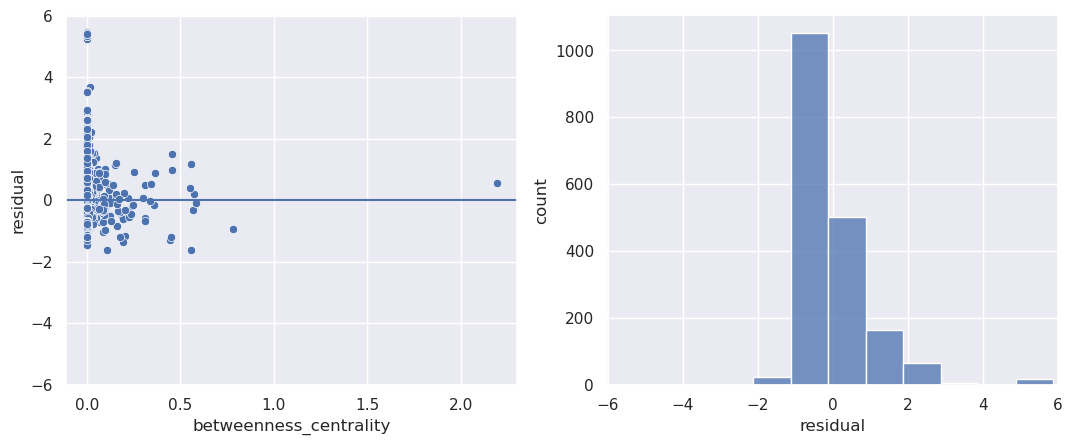

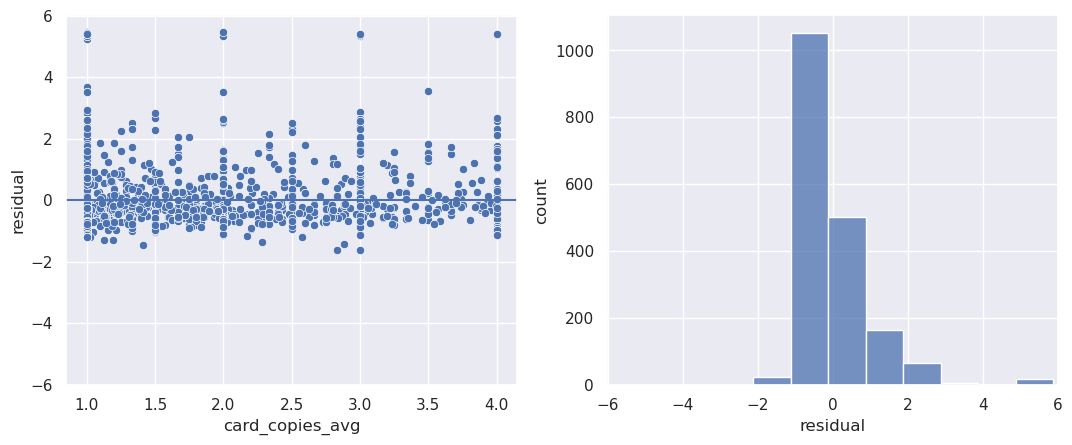

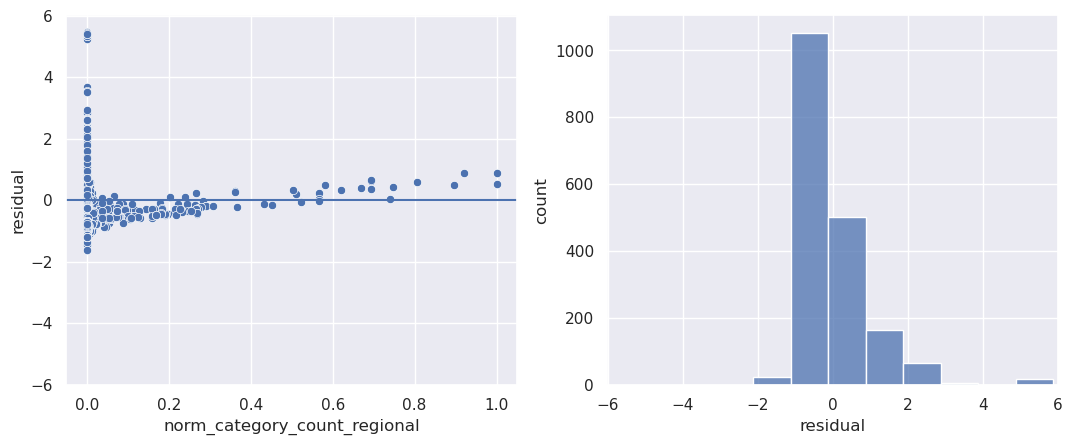

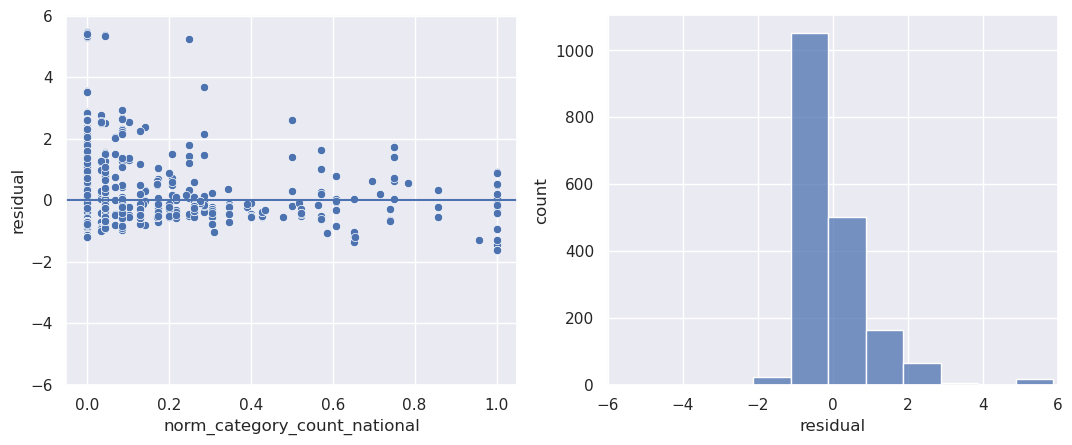

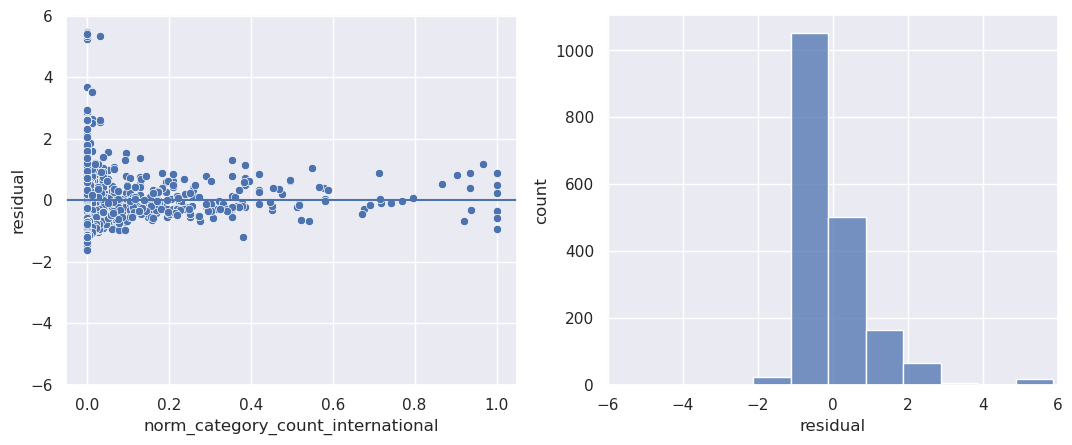

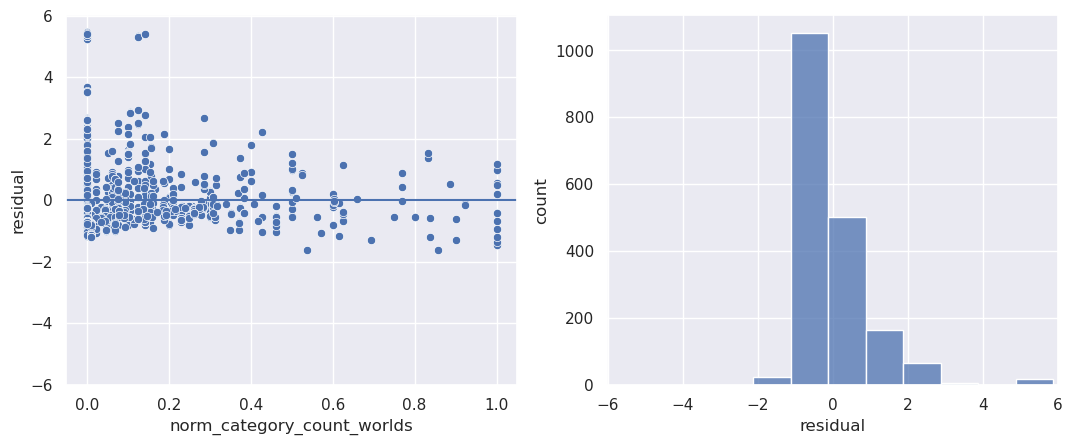

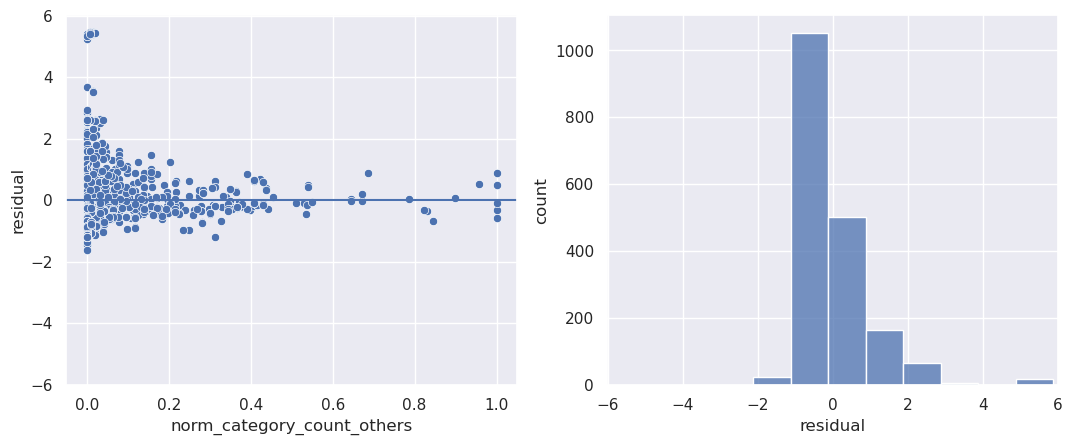

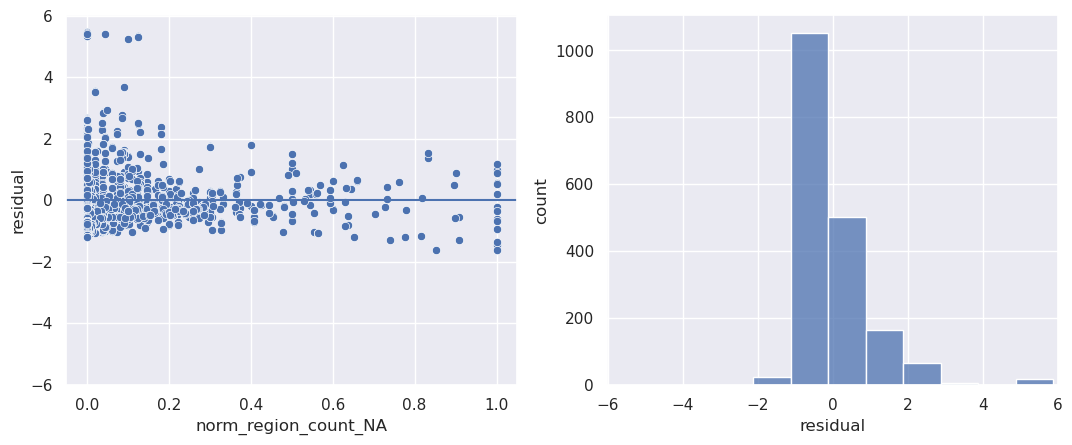

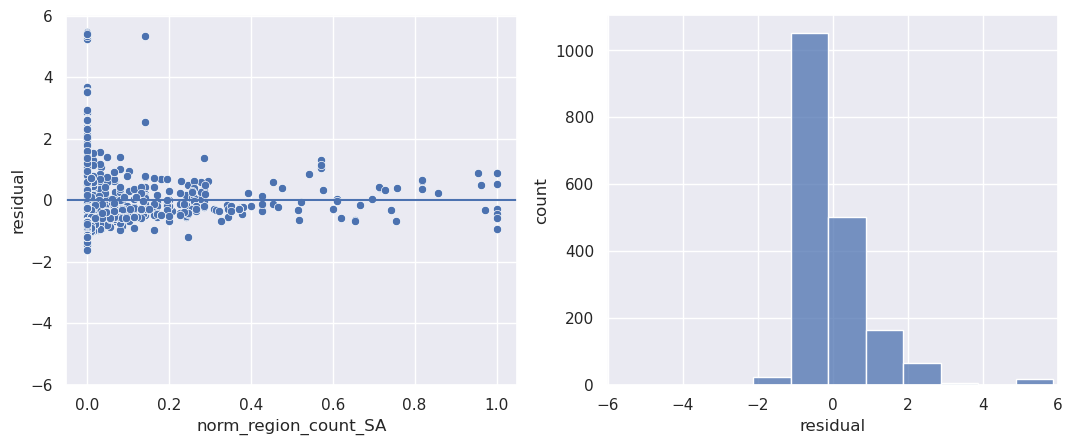

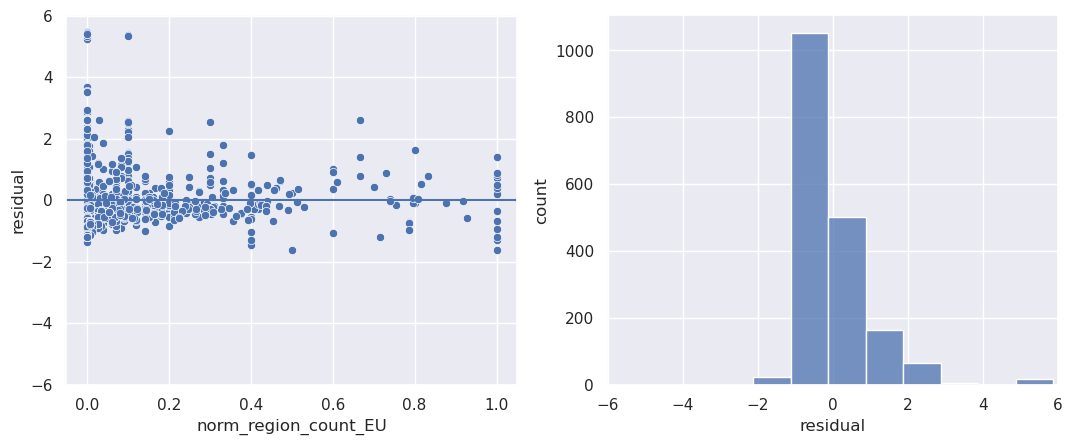

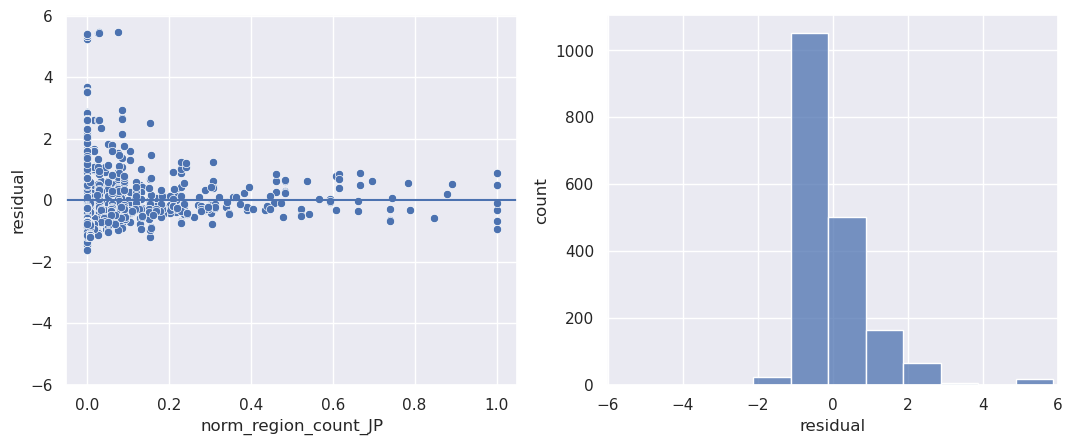

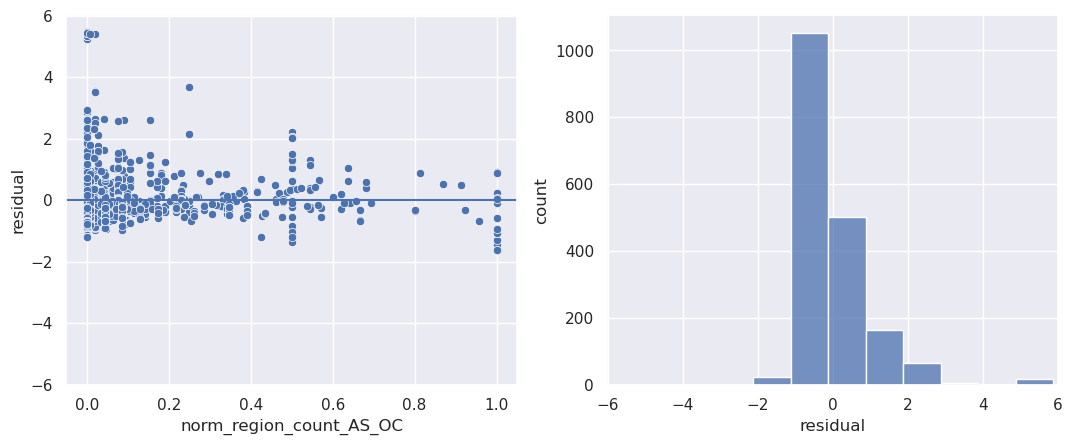

In [13]:
for col in name_var_x.split(' + '):
    result.plot_residuals(data[col])

## Regressão (hipótese 2)

Modelo linear no qual betweenness_centrality é a variável dependente e variáveis categóricas são as independentes

In [14]:
result = reg.linear(data=data, formula=f'betweenness_centrality ~ card_copies_avg + norm_category_count_regional + norm_category_count_national + norm_category_count_international + norm_category_count_worlds + norm_category_count_others + norm_region_count_NA + norm_region_count_EU + norm_region_count_SA + norm_region_count_JP + norm_region_count_AS_OC') # dependente à esquerda!
result.micro_summary()

variable,coefficient,std error,p-value
card_copies_avg,-0.006003,0.001498,0.000064
norm_category_count_regional,-0.142922,0.025428,0.000000
norm_category_count_national,-0.058093,0.013225,0.000012
norm_category_count_international,-0.050150,0.023819,0.035390
norm_category_count_worlds,0.106847,0.015086,0.000000
norm_category_count_others,0.013996,0.028946,0.628776
norm_region_count_NA,0.153528,0.016387,0.000000
norm_region_count_EU,0.009763,0.015083,0.517538
norm_region_count_SA,0.027878,0.021687,0.198790
norm_region_count_JP,0.082102,0.023172,0.000405


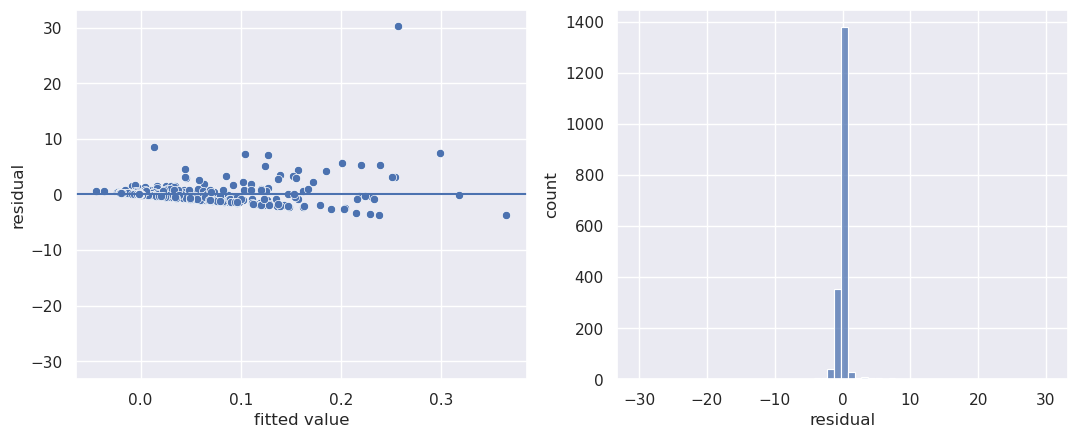

In [15]:
result.plot_residuals()

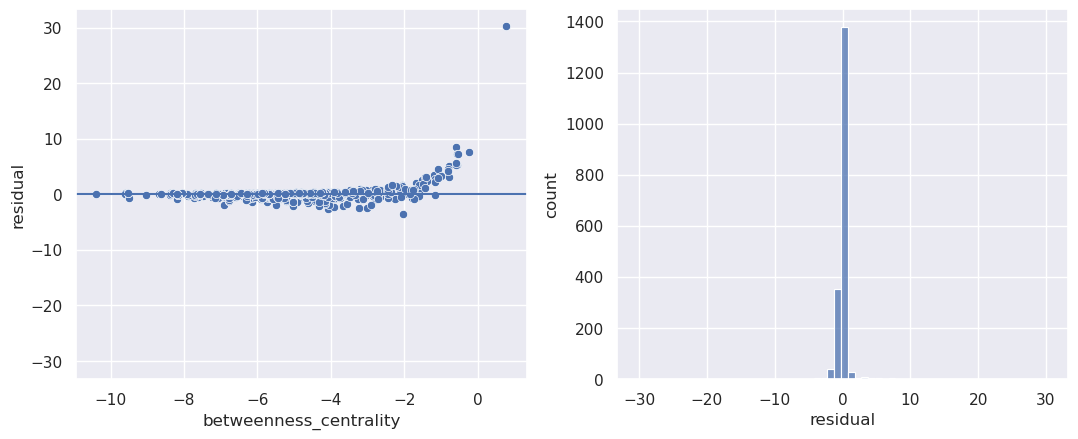

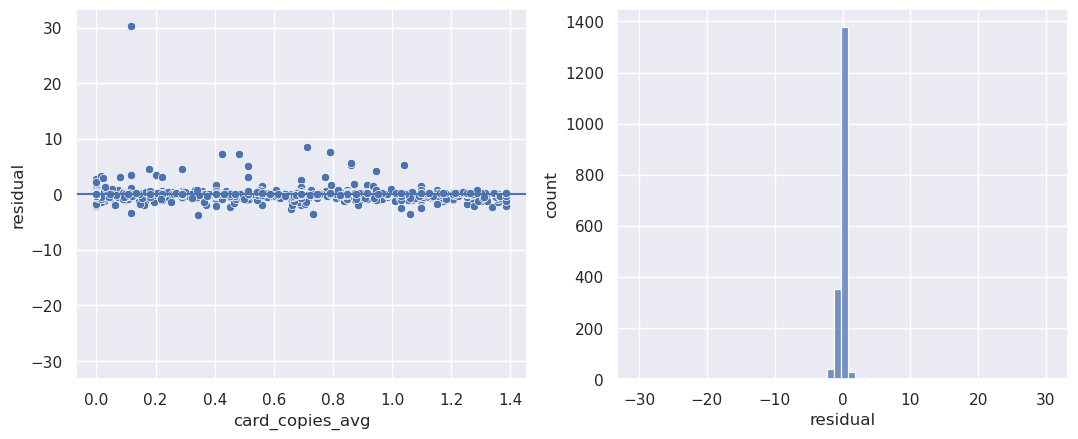

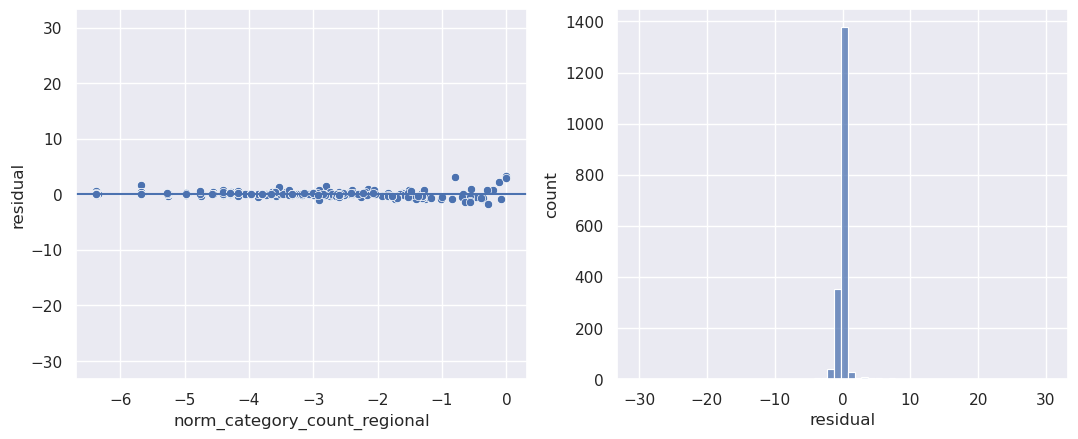

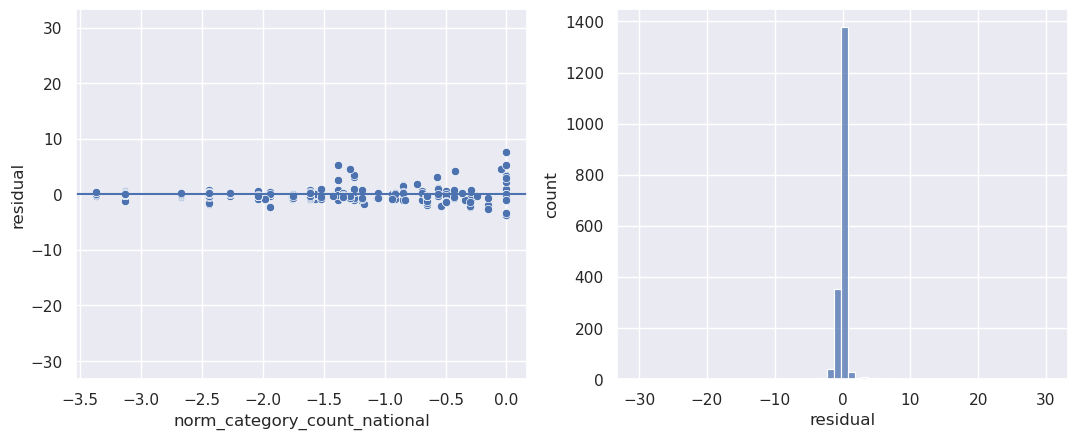

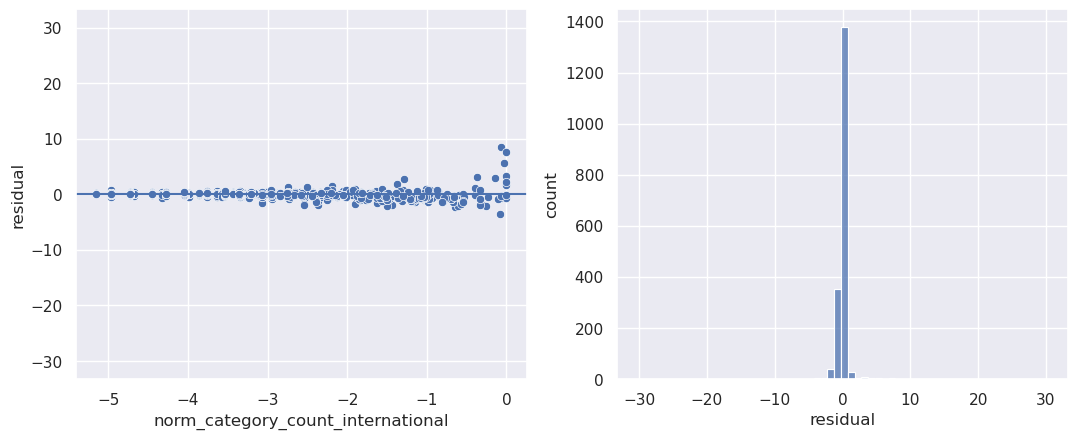

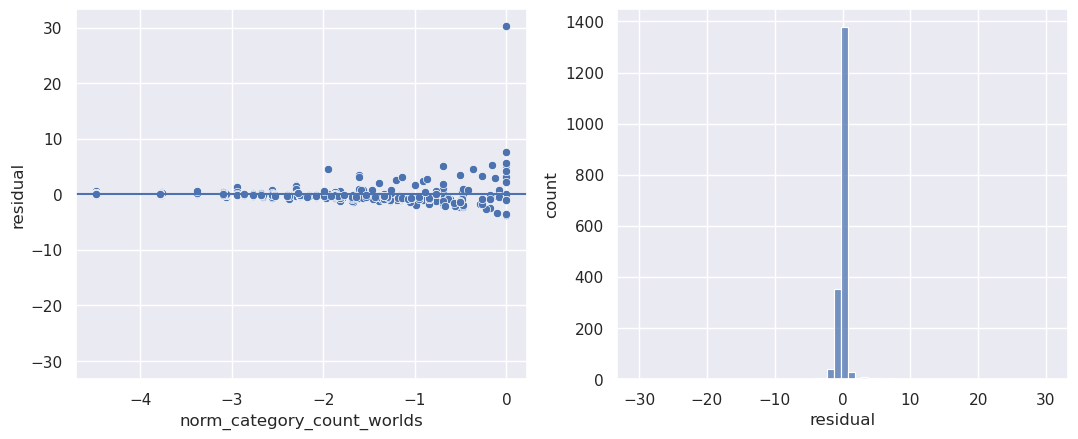

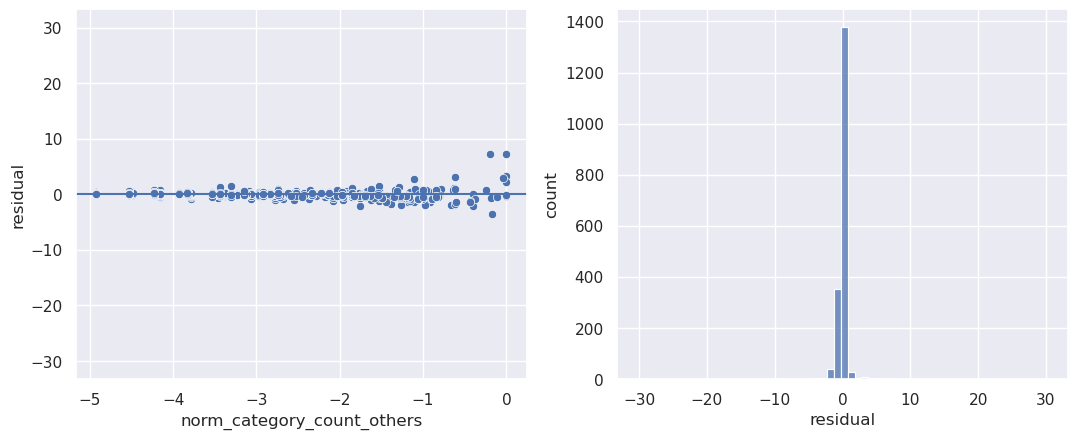

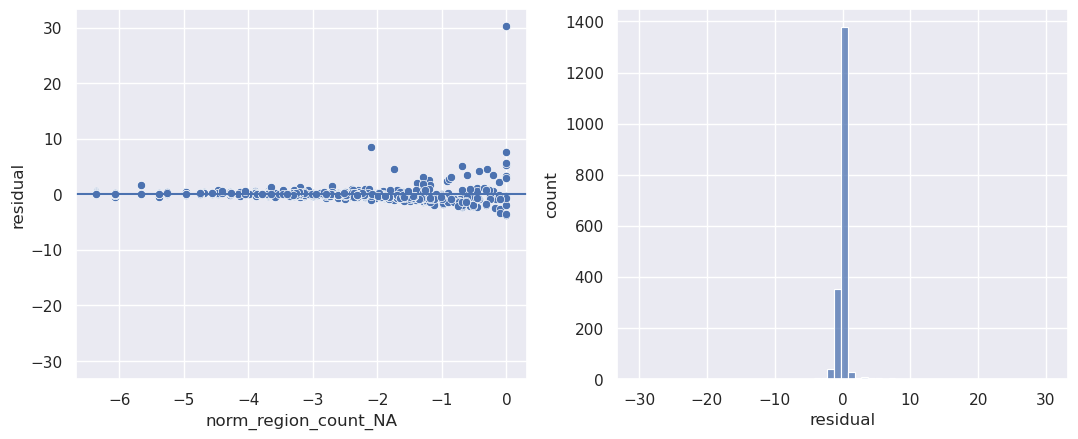

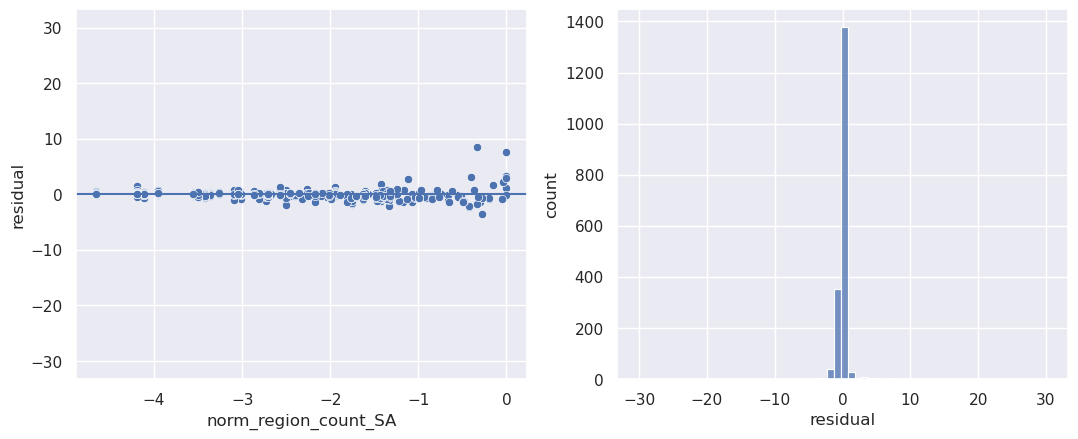

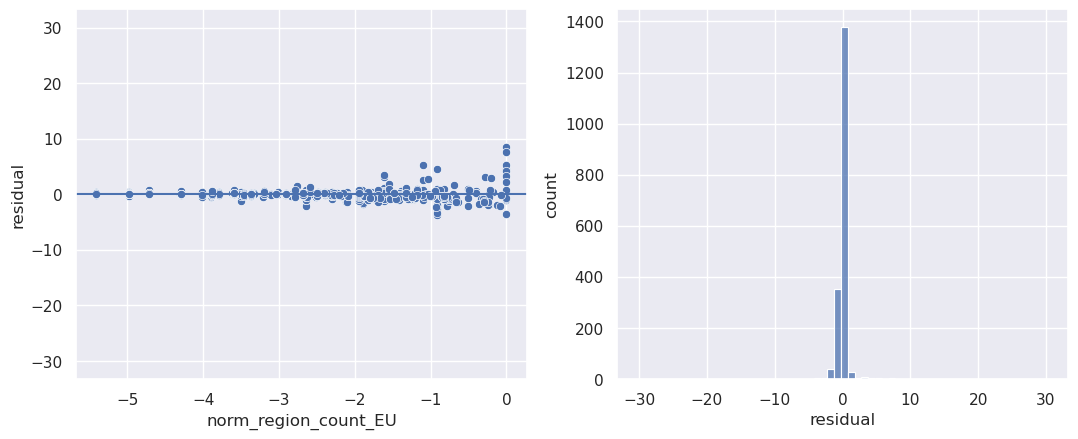

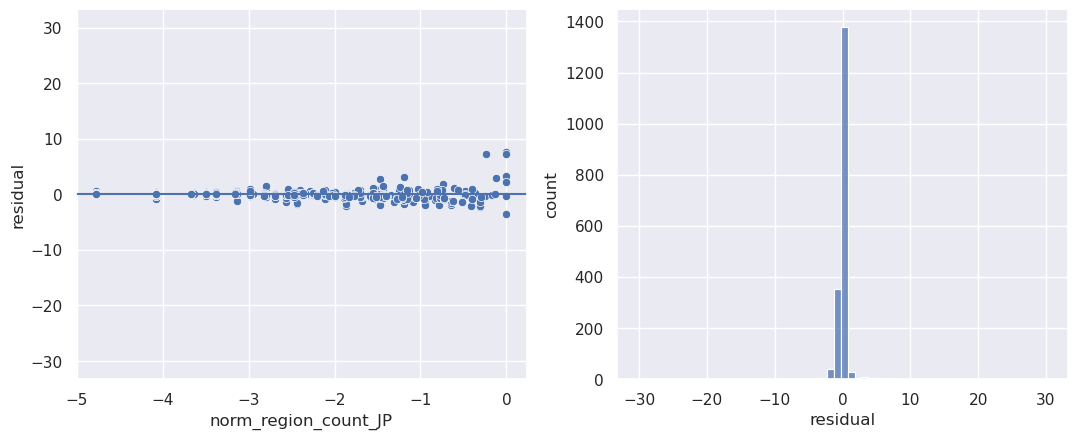

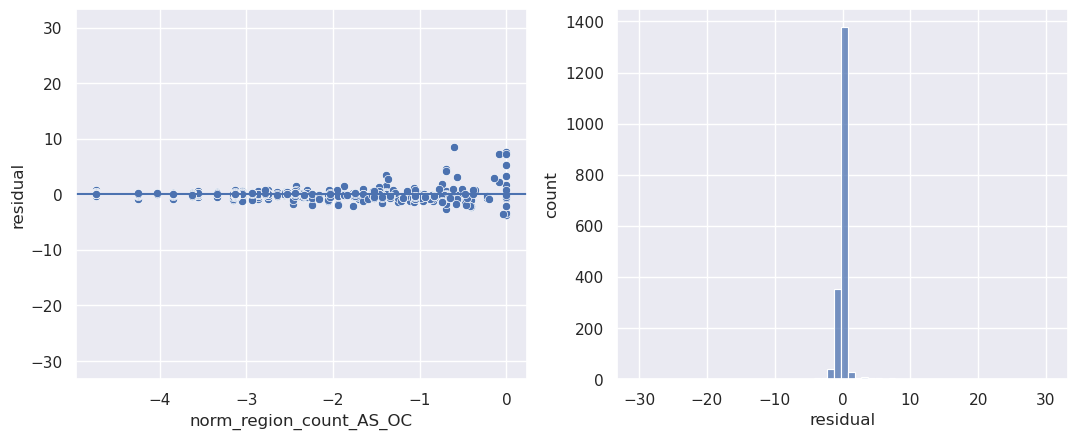

In [16]:
for col in name_var_x.split(' + '):
    result.plot_residuals(data[col].reset_index(drop=True).apply(np.log))

## Visualização da Rede

In [17]:
r = netpixi.render('subnetworks/pokemontcg_standard_2022.net.gz', infinite=True)

In [32]:
r.vertex_default(size=4, bwidth=1)

In [31]:
r.edge_default(width=1)

In [33]:
r.vertex_scale('betweenness', 5, 50)
r.vertex_set_key('id')

In [21]:
print(f"Número de vértices: {len(g.get_vertices())}")
print(f"Número de arestas: {len(g.get_edges())}")

Número de vértices: 254
Número de arestas: 515


In [22]:
print(f"Densidade da rede: {gte.bipartite_density(g, 'bipartite', lambda value: bool(value))}")
print(f"Transitividade da rede: {g.transitivity()}")

Densidade da rede: 8.687584
Transitividade da rede: 0.0


In [23]:
degrees = g.get_total_degrees()

In [24]:
degrees.describe()

count    254.000000
mean       4.055118
std        7.328333
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       70.000000
dtype: float64

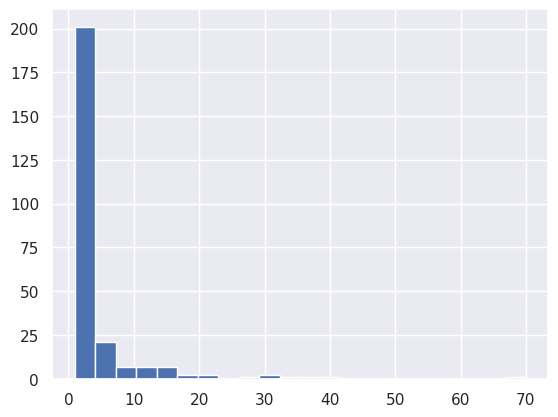

In [25]:
degrees.hist(bins = int(np.sqrt(len(g.get_edges() ) ) ) );

In [26]:
dst.not_normal(degrees)

5.804854898030216e-63

In [27]:
dst.more_powerlaw_than_lognormal(degrees)

Calculating best minimal value for power law fit


(False, 0.7166951059382756)

In [28]:
dst.more_powerlaw_than_exponential(degrees)

Calculating best minimal value for power law fit


(True, 0.605702496274559)

In [29]:
g.describe_distances()

count    64516.000000
mean         3.531155
std          1.046640
min          0.000000
max          6.000000
dtype: float64

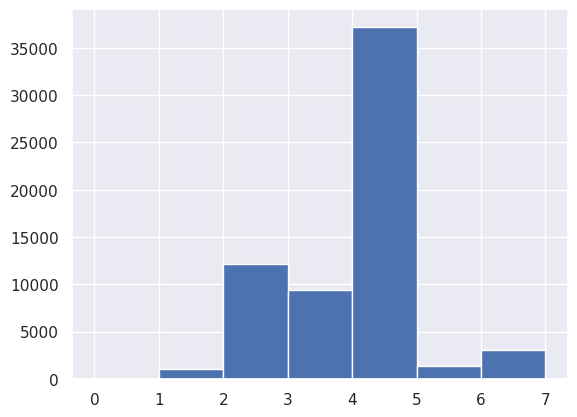

In [30]:
g.hist_distances()